In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
from sklearn.metrics import mean_squared_error

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, Flatten
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import math
from sklearn.metrics import mean_squared_error
from keras.callbacks import EarlyStopping
from keras.layers import ConvLSTM2D

In [10]:
# Load your dataset
# Replace this with your data loading code
data = pd.read_csv('../south dakota weather data/South Dakota climate Data.csv')

In [11]:
# Choose the target columns (e.g., 'Avg. Temp', 'Min. Temp', 'Max. Temp', 'Precipitation', 'Heating Degrees Days', 'Cooling Degrees Days')
data = data[['Avg. Temp', 'Min. Temp', 'Max. Temp', 'Precipitation', 'Heating Degrees Days']].values
data = data.astype('float32') #convert values to float

In [12]:
#LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1)) #Also try QuantileTransformer
data = scaler.fit_transform(data)

In [13]:
data

array([[0.79322034, 0.8188495 , 0.7704402 , 0.33234861, 0.04745255],
       [0.8677966 , 0.90820074, 0.8333333 , 0.50812405, 0.00999001],
       [0.8587571 , 0.89351285, 0.8291404 , 0.37666175, 0.01798202],
       ...,
       [0.3864407 , 0.376989  , 0.39308175, 0.15066469, 0.55444556],
       [0.19548023, 0.20440637, 0.18763101, 0.10044312, 0.7327672 ],
       [0.13672316, 0.13586292, 0.13836476, 0.0945347 , 0.8876124 ]],
      dtype=float32)

In [14]:
# Define the train-test split ratio (80:20)
train_size = int(len(data) * 0.90)
test_size = len(data) - train_size
train, test = data[0:train_size, :], data[train_size:len(data), :]
print(len(train))
print(len(test))

1390
155


In [15]:
def to_sequences(dataset, seq_size=6, step_size=1, target_size=6):
    x = []
    y = []

    for i in range(0, len(dataset)-seq_size-target_size + 1, step_size):
        #print(i)
        window = dataset[i:(i+seq_size)]
        x.append(window)
        target = dataset[i + seq_size: i + seq_size + target_size]
        y.append(target)
    
    return np.array(x),np.array(y)

In [16]:
seq_size = 6  # Number of time steps to look back
step_size=1   # Number of steps that is going to increase for the next sequence
target_size=6 # Number of values that is going to generate as the output

In [17]:
trainX, trainY = to_sequences(train, seq_size, step_size, target_size)
testX, testY = to_sequences(test, seq_size, step_size, target_size)

In [18]:
trainX.shape

(1379, 6, 5)

In [19]:
trainY.shape

(1379, 6, 5)

In [20]:
testX.shape

(144, 6, 5)

In [21]:
testY.shape

(144, 6, 5)

In [22]:
from tensorflow.keras.layers import TimeDistributed

# Build the model
model = Sequential()
model.add(LSTM(50, input_shape=(seq_size, 5), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(5))  # Adjust the output shape to (5)

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

In [23]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 6, 50)             11200     
                                                                 
 dropout (Dropout)           (None, 6, 50)             0         
                                                                 
 lstm_1 (LSTM)               (None, 6, 50)             20200     
                                                                 
 dropout_1 (Dropout)         (None, 6, 50)             0         
                                                                 
 lstm_2 (LSTM)               (None, 6, 50)             20200     
                                                                 
 dropout_2 (Dropout)         (None, 6, 50)             0         
                                                                 
 dense (Dense)               (None, 6, 5)              2

In [24]:
# Train the model
history = model.fit(trainX, trainY, epochs=100, batch_size=50, validation_data=(testX, testY), callbacks=[early_stopping])

Epoch 1/100
28/28 [==============================] - 4s 35ms/step - loss: 0.1841 - mean_absolute_error: 0.3513 - val_loss: 0.1170 - val_mean_absolute_error: 0.2736
Epoch 2/100
28/28 [==============================] - 0s 9ms/step - loss: 0.1085 - mean_absolute_error: 0.2626 - val_loss: 0.0901 - val_mean_absolute_error: 0.2413
Epoch 3/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0821 - mean_absolute_error: 0.2305 - val_loss: 0.0657 - val_mean_absolute_error: 0.2089
Epoch 4/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0576 - mean_absolute_error: 0.1910 - val_loss: 0.0409 - val_mean_absolute_error: 0.1535
Epoch 5/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0364 - mean_absolute_error: 0.1447 - val_loss: 0.0242 - val_mean_absolute_error: 0.1137
Epoch 6/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0253 - mean_absolute_error: 0.1206 - val_loss: 0.0174 - val_mean_absolute_error: 0.0979
Epoch 7/100
28/28 [==

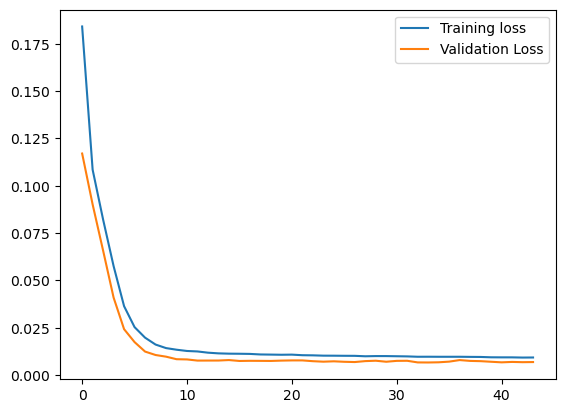

In [25]:
plt.plot(history.history['loss'],label='Training loss')
plt.plot(history.history['val_loss'],label='Validation Loss')
plt.legend()

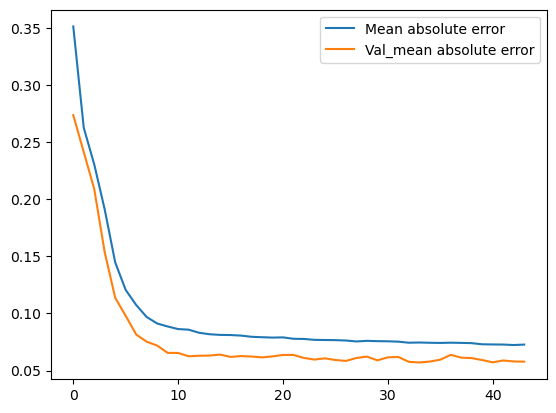

In [26]:
plt.plot(history.history['mean_absolute_error'],label='Mean absolute error')
plt.plot(history.history['val_mean_absolute_error'],label='Val_mean absolute error')
plt.legend()

In [27]:
trainX.shape

(1379, 6, 5)

In [28]:
# Make predictions on the test data
testPredict = model.predict(testX)

# Inverse transform the predictions to the original scale
#testPredict = scaler.inverse_transform(testPredict)

# Optionally, inverse transform the testY (true values) if it was scaled
#testY = scaler.inverse_transform(testY)

# Now, you can compare the testY (true values) with the predicted values
# For example, to check the predictions for the first sequence:
print("True Values (TestY):")
print(testY[0])  # This contains the true values for the first sequence

print("Predicted Values:")
print(testPredict[0])  # This contains the predicted values for the first sequence

5/5 [==============================] - 1s 2ms/step
True Values (TestY):
[[0.60112995 0.61811507 0.5849057  0.6129985  0.26273727]
 [0.48700568 0.49694005 0.4769392  0.11669128 0.4110889 ]
 [0.46101692 0.47368422 0.4486373  0.06942392 0.44905096]
 [0.3062147  0.3243574  0.29140463 0.07385524 0.5949051 ]
 [0.12655367 0.13341494 0.12054508 0.1536189  0.8906094 ]
 [0.29265538 0.3133415  0.2746331  0.10782865 0.66933066]]
Predicted Values:
[[0.73066497 0.75501025 0.71082276 0.32308376 0.12343688]
 [0.5951604  0.6114906  0.57625866 0.2669021  0.25966576]
 [0.45171165 0.46421784 0.43432522 0.1863478  0.43841064]
 [0.32629684 0.33904827 0.30893603 0.10959514 0.5928519 ]
 [0.25599724 0.27174887 0.23695521 0.06068679 0.69575423]
 [0.29344243 0.31088877 0.27373958 0.06612056 0.64140844]]


In [29]:
# After training, you can make predictions on the test data
testPredict = model.predict(testX)

5/5 [==============================] - 0s 3ms/step


In [30]:
# Inverse transform the predictions to the original scale if you had previously scaled your data using a MinMaxScaler
#testPredict = scaler.inverse_transform(testPredict)

In [31]:
trainPredict = model.predict(trainX)

# Inverse transform the predictions to the original scale
#trainPredict = scaler.inverse_transform(trainPredict)

# Optionally, inverse transform the trainY (true values) if it was scaled
#trainY = scaler.inverse_transform(trainY)

# Now, you can compare the trainY (true values) with the predicted values
# For example, to check the predictions for the first sequence:
print("True Values (TrainY):")
print(trainY[0])  # This contains the true values for the first sequence

print("Predicted Values:")
print(trainPredict[0])  # This contains the predicted values for the first sequence


44/44 [==============================] - 0s 2ms/step
True Values (TrainY):
[[0.32881355 0.36597306 0.2976939  0.16248153 0.6228771 ]
 [0.30847457 0.32190943 0.29559746 0.10339733 0.6143856 ]
 [0.2836158  0.32680538 0.24633124 0.11669128 0.7117882 ]
 [0.23050848 0.25948593 0.20440254 0.20827177 0.7557442 ]
 [0.38757062 0.40758872 0.3710692  0.07090104 0.5194805 ]
 [0.6180791  0.61933905 0.6163522  0.08124077 0.24075924]]
Predicted Values:
[[0.32997045 0.35050625 0.3155443  0.10830166 0.5833764 ]
 [0.25423005 0.2761422  0.2390652  0.06092481 0.69776756]
 [0.2619225  0.28571174 0.2449905  0.05405037 0.6954195 ]
 [0.2761407  0.30035967 0.2582145  0.05228933 0.6759784 ]
 [0.36616927 0.38829488 0.34880012 0.08501561 0.5448056 ]
 [0.5746358  0.59287494 0.5597369  0.16898948 0.28728116]]


In [32]:
trainPredict = model.predict(trainX)

44/44 [==============================] - 0s 2ms/step


In [33]:
# Inverse transform the predictions to the original scale if you had previously scaled your data using a MinMaxScaler
#testPredict = scaler.inverse_transform(testPredict)

In [34]:
# You can also optionally inverse transform the testY (true values) if it was scaled
# testY = scaler.inverse_transform(testY)

# Calculate RMSE for the test data
#testScore = math.sqrt(mean_squared_error(testY, testPredict))
#print('Test Score: %.2f RMSE' % (testScore))

# Calculate RMSE for the test data
testScore = math.sqrt(mean_squared_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5)))
print('Test Score: %.2f RMSE' % (testScore))


Test Score: 0.08 RMSE


In [35]:
# You can also optionally inverse transform the testY (true values) if it was scaled
# testY = scaler.inverse_transform(testY)

# Calculate RMSE for the test data
#trainScore = math.sqrt(mean_squared_error(trainY, trainPredict))
#print('Train Score: %.2f RMSE' % (trainScore))

# Calculate RMSE for the train data
trainScore = math.sqrt(mean_squared_error(trainY.reshape(-1, 5), trainPredict.reshape(-1, 5)))
print('Train Score: %.2f RMSE' % (trainScore))

Train Score: 0.08 RMSE


In [36]:
from sklearn.metrics import mean_absolute_error

# Calculate the Mean Absolute Error
#mae = mean_absolute_error(testY, testPredict)
#print("Mean Absolute Error (MAE):", mae)

# Calculate the Mean Absolute Error
mae = mean_absolute_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5))
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.05782311


In [37]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the Mean Absolute Percentage Error
mae = mean_absolute_percentage_error(testY.reshape(-1, 5), testPredict.reshape(-1, 5))
print("Mean Absolute Percentage Error (MAPE):", mae)

Mean Absolute Percentage Error (MAPE): 0.3204997


In [38]:
from sklearn.metrics import mean_absolute_percentage_error

# Calculate the Mean Absolute Percentage Error

trainScore = mean_absolute_percentage_error(trainY.reshape(-1, 5), trainPredict.reshape(-1, 5))
print("Mean Absolute Percentage Error (MAPE):", mae)

Mean Absolute Percentage Error (MAPE): 0.3204997


In [39]:
from sklearn.metrics import accuracy_score
# Set threshold 
threshold = 0.5
# Binarize predictions 
test_pred_binary = (testPredict > threshold).astype(int)
test_pred_binary = test_pred_binary.flatten() 

# Binarize true values
test_true_binary = (testY > threshold).astype(int) 
test_true_binary = test_true_binary.flatten()

# Calculate accuracy
test_accuracy = accuracy_score(test_true_binary, test_pred_binary)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9488425925925926


In [40]:
# Set threshold
threshold = 0.5

# Binarize train predictions
train_pred_binary = (trainPredict > threshold).astype(int)

# Binarize train true values
train_true_binary = (trainY > threshold).astype(int)

# Flatten arrays 
train_pred_binary = train_pred_binary.flatten()
train_true_binary = train_true_binary.flatten()

# Calculate accuracy
train_accuracy = accuracy_score(train_true_binary, train_pred_binary)

print("Train Accuracy:", train_accuracy)

Train Accuracy: 0.9429054870679237


In [41]:
predictions = model.predict(testX)

5/5 [==============================] - 0s 3ms/step


In [42]:
threshold = 0.5
binary_predictions = (predictions > threshold).astype(int)
binary_ground_truth = (testY > threshold).astype(int)

In [43]:
from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(binary_ground_truth.flatten(), binary_predictions.flatten())
recall = recall_score(binary_ground_truth.flatten(), binary_predictions.flatten())
f1 = f1_score(binary_ground_truth.flatten(), binary_predictions.flatten())

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Precision: 0.9897901304594441
Recall: 0.8957905544147844
F1-score: 0.9404473187819994


In [44]:
from sklearn.metrics import mean_squared_error

# Assuming predictions and ground truth are NumPy arrays or lists
mse = mean_squared_error(testY.flatten(), predictions.flatten())

print("Mean Squared Error:", mse)

Mean Squared Error: 0.006887497


In [45]:
from sklearn.metrics import r2_score

# Assuming predictions and ground truth are NumPy arrays or lists
r2 = r2_score(testY.flatten(), predictions.flatten())

print("R-squared (R2):", r2)

R-squared (R2): 0.9045726220852164
